In [68]:
#install unzip in notebook
!sudo apt-get install -y unzip zip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unzip zip
0 upgraded, 2 newly installed, 0 to remove and 50 not upgraded.
Need to get 335 kB of archives.
After this operation, 1231 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 unzip amd64 6.0-25ubuntu1.1 [168 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 zip amd64 3.0-11build1 [167 kB]
Fetched 335 kB in 0s (2045 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 25583 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-25ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-25ubuntu1.1) ...
Selecting previously unselected package zip.
Preparing to unpack .../zip_3.0-11build1_amd64.deb ...
Unpacking zip (3.0-11build1) ...
Setting up unzip (6.0-25ubuntu1.1) 

In [69]:
!pip install boto3 datasets


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [70]:
import boto3

s3 = boto3.resource('s3', endpoint_url='https://storage.s3.mlops.wogra.com')
bucket = s3.Bucket('data')

In [71]:
bucket.download_file('dlr/dataset_tapelegen.zip', 'data.zip')

In [72]:
# extreact zip file to data folder
!rm -r data
!unzip data.zip -d data

Archive:  data.zip
   creating: data/dataset_tapelegen/
  inflating: data/dataset_tapelegen/dataset_info.json  
  inflating: data/dataset_tapelegen/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/state.json  
  inflating: data/dataset_tapelegen/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/data-00002-of-00003.arrow  
 extracting: data/dataset_tapelegen/dataset_dict.json  
   creating: data/dataset_tapelegen/train/
  inflating: data/dataset_tapelegen/train/dataset_info.json  
  inflating: data/dataset_tapelegen/train/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/state.json  
  inflating: data/dataset_tapelegen/train/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/data-00002-of-00003.arrow  


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 11.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 47.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 7.0.0
    Uninstalling pyarrow-7.0.0:
      Successfully uninstalled pyarrow-7.0.0

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:

# create a dataset for images in the folders and use the folder name as label
from datasets import load_from_disk

dataset = load_from_disk("data/dataset_tapelegen/")
dataset


/home/ray/anaconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image', 'label'],
    num_rows: 73749
})

In [4]:
# remove all items from dataset with mean 0 but dont use remove rows which not exists as method
import numpy as np
clean_dataset = dataset.filter(lambda example: np.mean(example["image"]) != 0)

Loading cached processed dataset at /home/jovyan/work/data/dataset_tapelegen/cache-eff110bde0e04316.arrow


In [5]:
clean_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 72287
})

In [16]:
pip install transformers==4.26.1 evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import transformers

checkpoint = "google/vit-base-patch16-224-in21k"

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(
    checkpoint
)

print(feature_extractor.size)
print(feature_extractor.image_mean)
print(feature_extractor.image_std)

{'height': 224, 'width': 224}
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]


/home/ray/anaconda3/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [8]:
from torchvision import transforms
import numpy as np

def preprocess(image):
    # convert image to tensor
    tensor = transforms.ToTensor()(image)
    tensor = tensor - np.mean(tensor.numpy()) + 128
    tensor[tensor < 0] = 0
    tensor[tensor > 255] = 255
    tensor = tensor / 255
    # repeat the tensor two ore times to get 3 channels and use the repeat function
    tensor = tensor.repeat(3, 1, 1)
    return tensor



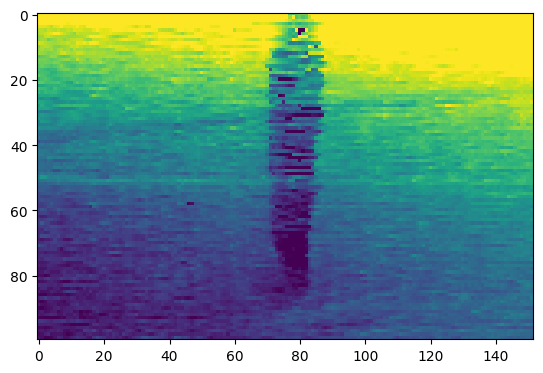

In [9]:
# take an exemplary image and preprocess it and plot it
import matplotlib.pyplot as plt
import numpy as np

img = clean_dataset[0]['image']
tensor = preprocess(img)
plt.imshow(tensor[0])
plt.show()


In [10]:
from torchvision import transforms


class Preprocess:
    def __init__(self):
        self.transforms = transforms.Compose(
            [
                transforms.Lambda(preprocess),
                transforms.CenterCrop(224),
            ]
        )

    def __call__(self, example_batch):
        example_batch["preprocessed_image"] = [
            self.transforms(img) for img in example_batch["image"]
        ]
        return example_batch
    
clean_dataset.set_transform(Preprocess())
clean_dataset[0]["preprocessed_image"]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [11]:
clean_dataset.features["label"].names

['g', 'n', 'o']

In [12]:
# pick random item from clean_date
import random
def random_pick(clean_data):
    index = random.randint(0, len(clean_data) - 1)
    return index

random_ids = []
number_of_examples = 3
for i in range(len(clean_dataset.features["label"].names)):
    for j in range(number_of_examples):
        while True:
            index = random_pick(clean_dataset)
            if clean_dataset.features["label"].names[clean_dataset[index]["label"]] == clean_dataset.features["label"].names[i]:
                random_ids.append(index)
                break

print(random_ids)
random_labels = [clean_dataset[i]["label"] for i in random_ids]
print(random_labels)


[8533, 1926, 8377, 54487, 50069, 8984, 71121, 72282, 70576]
[0, 0, 0, 1, 1, 1, 2, 2, 2]


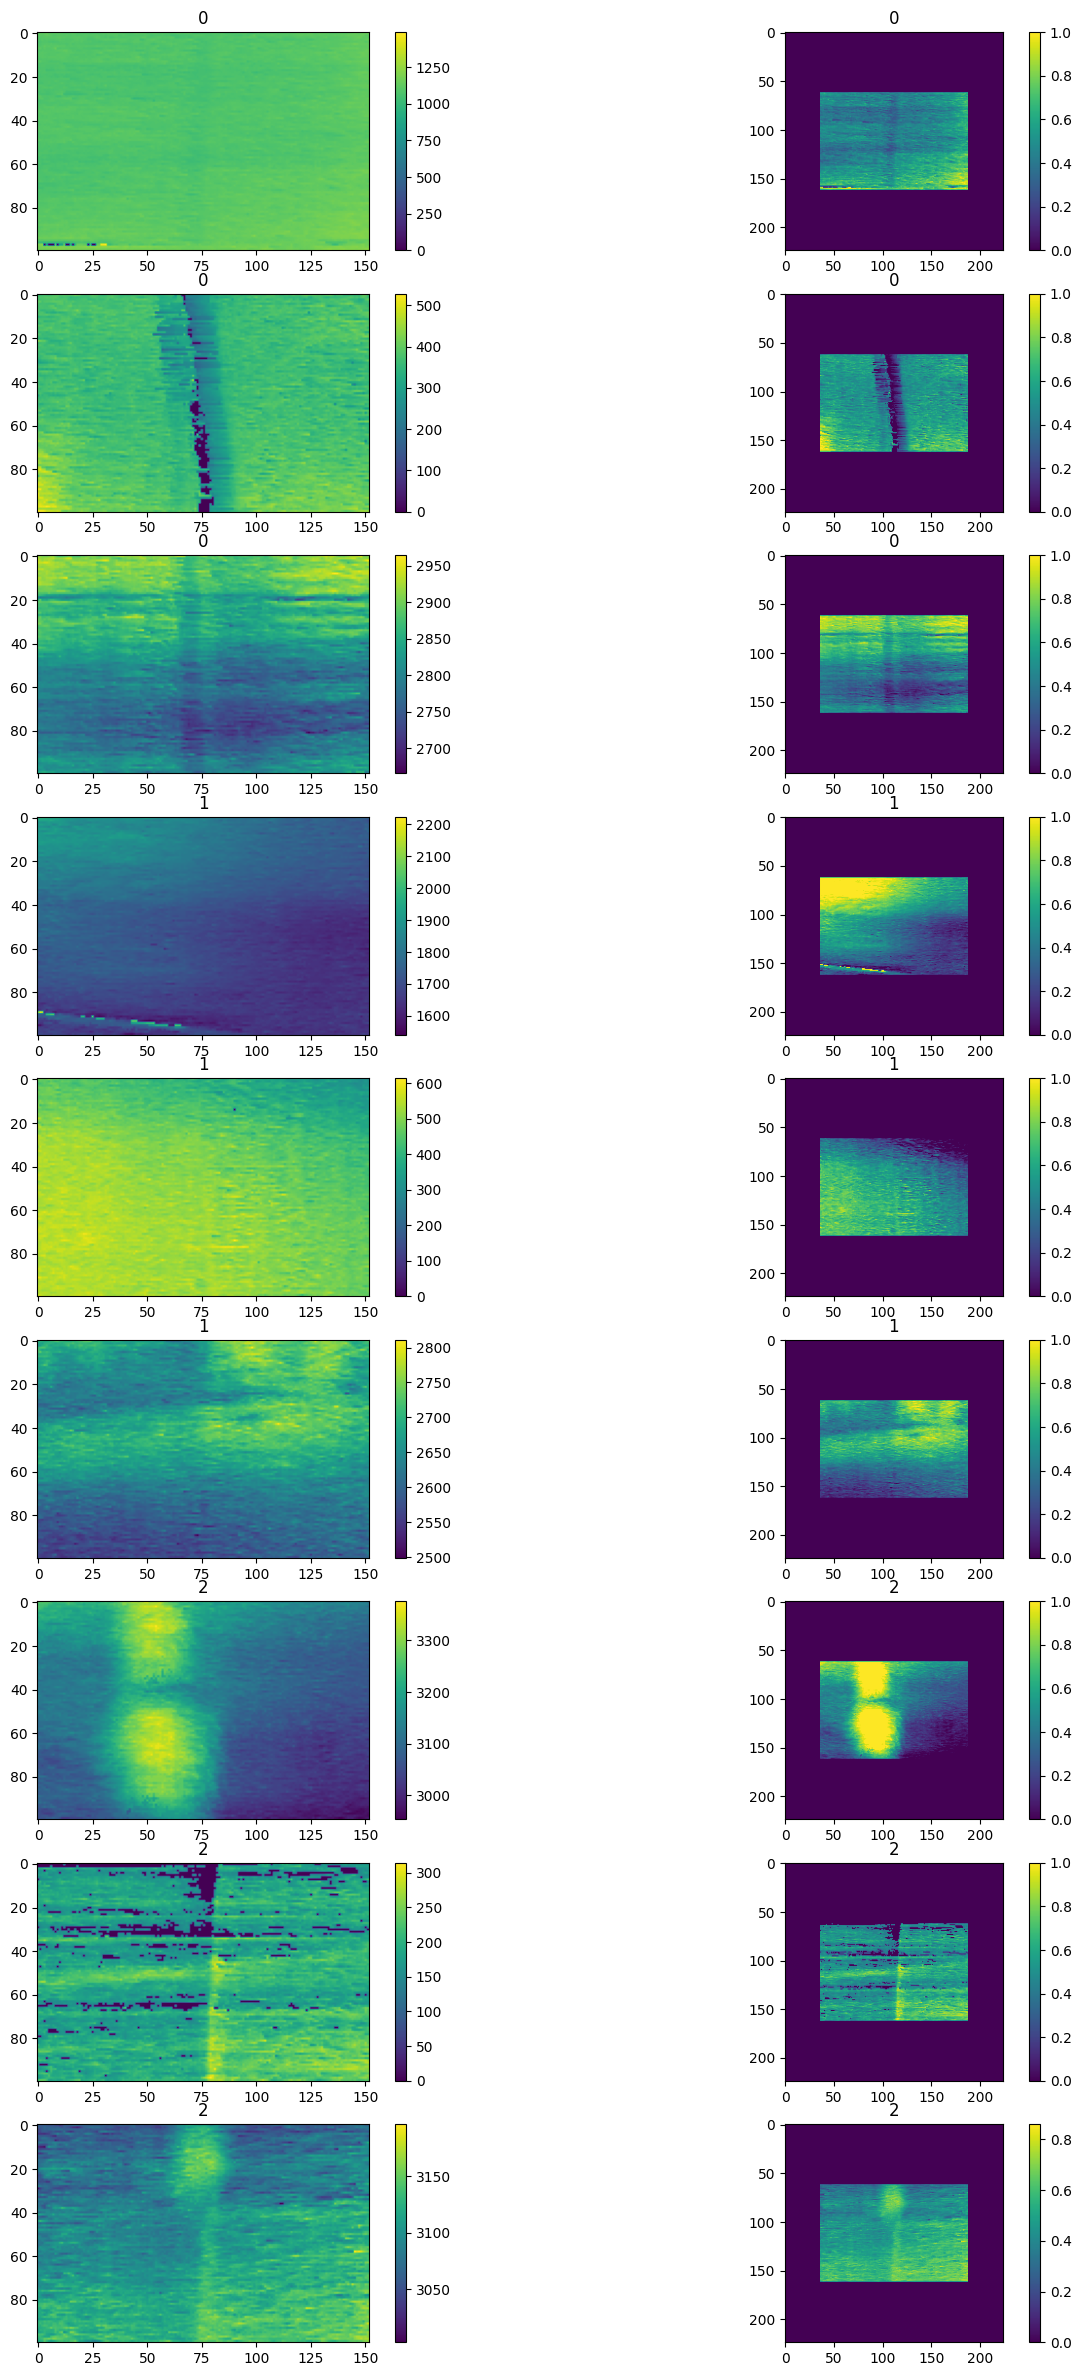

In [13]:
#plot the same images as above but dont use the normalized images but the pixel values

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(len(random_ids), 2, figsize=(15, 30))

# Plotting the images and adding color bar
for i, j in zip(range(len(random_ids)), random_ids):
    img_array = np.array(clean_dataset[j]['image'])
    img = axs[i, 0].imshow(img_array)
    axs[i, 0].set_title(clean_dataset[j]['label'])
    axs[i, 0].figure.colorbar(img, ax=axs[i, 0])
    
    img_array = np.array(clean_dataset[j]['preprocessed_image'][0])
    img = axs[i, 1].imshow(img_array)
    axs[i, 1].set_title(clean_dataset[j]['label'])
    axs[i, 1].figure.colorbar(img, ax=axs[i, 1])

plt.show()


In [14]:
labels = clean_dataset.features["label"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [15]:

from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="my_tapelegen_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


In [17]:
import evaluate
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [21]:
# 90% train, 10% test + validation
train_testvalid = dataset.train_test_split(test_size=0.1)

In [22]:
train_testvalid

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 66374
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7375
    })
})

In [24]:
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

In [28]:
from datasets import DatasetDict
train_test_valid_dataset = DatasetDict({
    "train": train_testvalid["train"],
    "test": test_valid["test"],
    "valid": test_valid["train"]})


In [29]:

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [30]:
trainer.train()

/home/ray/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 66374
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 4
  Total optimization steps = 1035
  Number of trainable parameters = 85800963


RuntimeError: Could not infer dtype of TiffImageFile